(2477, 5)
0.387374064716121


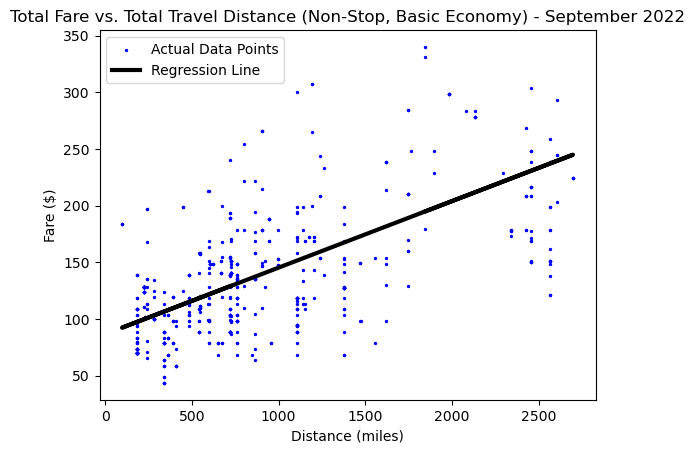

(19374, 5)
0.4130010866114635


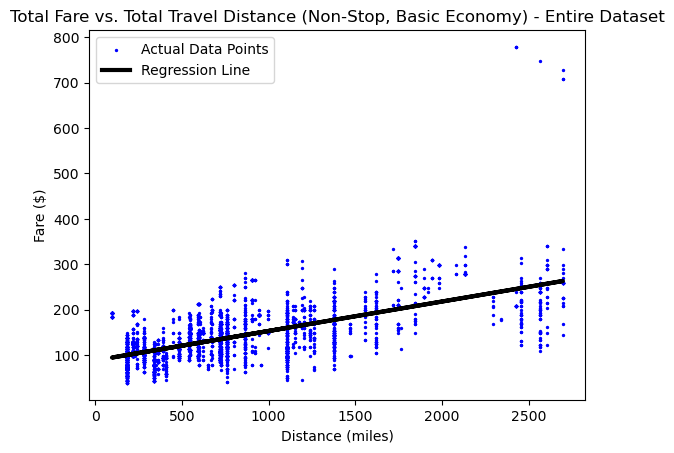

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def runLinReg(startDate, endDate, title):
    flightdf = pd.read_csv('flight_data_clean.csv')
    flightdf = flightdf[['flightDate', 'totalFare', 'totalTravelDistance', 'isBasicEconomy', 'isNonStop']]
    # filter data to only include flights within date range passed
    filtered = flightdf[(flightdf['flightDate'] >= startDate) & (flightdf['flightDate'] <= endDate)].copy()

    filtered.dropna(inplace=True)
    # filter data to only include basic economy and non-stop flights
    filtered = filtered[(filtered['isBasicEconomy'] == True) & (filtered['isNonStop'] == True)]

    print(filtered.shape)

    X = np.array(filtered['totalTravelDistance']).reshape(-1, 1)
    Y = np.array(filtered['totalFare']).reshape(-1, 1)

    # split columns into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    # create linear regression model
    regr = LinearRegression()
    regr.fit(X_train, y_train)

    # print the r squared value
    print(regr.score(X_test, y_test))

    # predict prices based on test set
    y_pred = regr.predict(X_test)

    plt.scatter(X_test, y_test, color='b', s=2)
    plt.plot(X_test, y_pred, color='k', linewidth=3)

    plt.title(title)
    plt.xlabel('Distance (miles)')
    plt.ylabel('Fare ($)')
    plt.legend(['Actual Data Points', 'Regression Line'])

    plt.show()

runLinReg('2022-09-01', '2022-09-30', 'Total Fare vs. Total Travel Distance (Non-Stop, Basic Economy) - September 2022')
runLinReg('2022-04-12', '2022-10-12', 'Total Fare vs. Total Travel Distance (Non-Stop, Basic Economy) - Entire Dataset')

## Folium map visualizing the number of flight departures from each airport.
#### Size of circle proportional to number.
#### Click circles to see number of flights and IATA airport code.  


In [18]:
import pandas as pd
import numpy as np
import folium
from IPython.display import display

flightdf = pd.read_csv('flight_data_clean.csv')
airportdf = pd.read_csv('airports.csv') # Contains airport codes, names, and locations

# drop all columns except startingAirport and destinationAirport
flightdf = flightdf.dropna()
flightdf = flightdf[['startingAirport', 'destinationAirport']]

airportdf = airportdf.dropna()
airportdf = airportdf[['IATA', 'LATITUDE', 'LONGITUDE']]


# Count the number of occurrences of each airport in flightdf

airportCounts = flightdf['startingAirport'].value_counts()
airportCountsDF = pd.DataFrame({'IATA': airportCounts.index, 'count': airportCounts.values})
# Makes a new dataframe with the counts of each airport and the airport's IATA code

airports_with_coords = pd.merge(airportCountsDF, airportdf, on='IATA', how='left')

map = folium.Map(location=[40.159,-100.908], zoom_start=4.4)
for index, row in airports_with_coords.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=row['count'] / 2000,  # Adjust the size of the circle based on the count of departures
        popup=f"{row['IATA']} - Departures: {row['count']}",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map)

display(map)

## Folium map visualizing the flight routes found within the dataset.



In [19]:
import pandas as pd
import folium
from IPython.display import display

# Visualize all the possible flight paths on a map using folium polylines

flightdf = pd.read_csv('flight_data_clean.csv')
airportdf = pd.read_csv('airports.csv') # Contains airport codes, names, and locations

# drop all columns except startingAirport and destinationAirport
flightdf = flightdf.dropna()
flightdf = flightdf[['startingAirport', 'destinationAirport']]

airportdf = airportdf.dropna()
airportdf = airportdf[['IATA', 'LATITUDE', 'LONGITUDE']]


uniqueFlights = flightdf.groupby(['startingAirport', 'destinationAirport']).size().reset_index().rename(columns={0:'count'})

# Merge the uniqueFlights dataframe with the airportdf dataframe to get the coordinates of each airport
uniqueFlights = pd.merge(uniqueFlights, airportdf, left_on='startingAirport', right_on='IATA', how='left', suffixes=('_start', '_end'))
uniqueFlights = pd.merge(uniqueFlights, airportdf, left_on='destinationAirport', right_on='IATA', how='left', suffixes=('_start', '_end'))


m = folium.Map(location=[40.159,-100.908], zoom_start=4)

for index, row in uniqueFlights.iterrows():
    start_coords = (row['LATITUDE_start'], row['LONGITUDE_start'])
    end_coords = (row['LATITUDE_end'], row['LONGITUDE_end'])
    folium.PolyLine(
        locations=[start_coords, end_coords],
        color='red',
        weight=.5
    ).add_to(m)

display(m)


0.5798621861373299


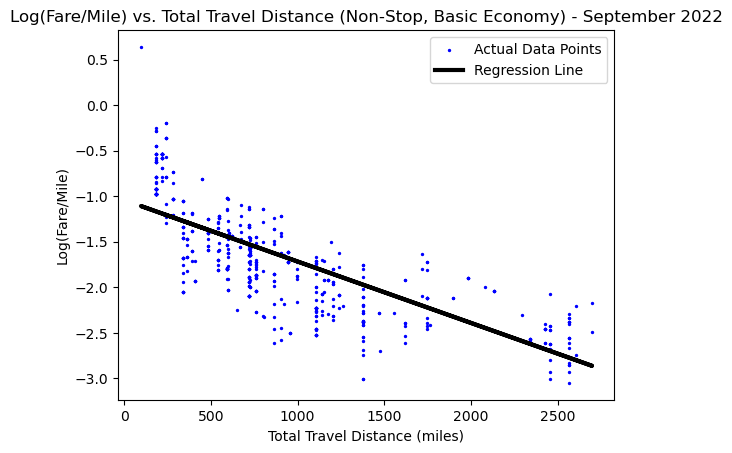

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

flightdf = pd.read_csv('flight_data_clean.csv')
flightdf = flightdf[['flightDate', 'totalFare', 'totalTravelDistance', 'isBasicEconomy', 'isNonStop']]

startDate = '2022-09-01'
endDate = '2022-09-30'

filtered = flightdf[(flightdf['flightDate'] >= startDate) & (flightdf['flightDate'] <= endDate)].copy()
filtered.dropna(inplace=True)
filtered = filtered[(filtered['isBasicEconomy'] == True) & (filtered['isNonStop'] == True)]
filtered = filtered[(filtered['totalFare'] < 600)]

# Take log of data due to exponential decay
filtered['log_fare_per_distance'] = np.log(filtered['totalFare'] / filtered['totalTravelDistance'])

# Define X and y
X = filtered[['totalTravelDistance']]
y = filtered['log_fare_per_distance']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Perform linear regression
regr = LinearRegression()
regr.fit(X_train, y_train)

# Evaluate the model
print(regr.score(X_test, y_test))

# Make predictions and plot
y_pred = regr.predict(X_test)

plt.scatter(X_test, y_test, color='b', s=2)
plt.plot(X_test, y_pred, color='k', linewidth=3)

plt.title('Log(Fare/Mile) vs. Total Travel Distance (Non-Stop, Basic Economy) - September 2022')
plt.xlabel('Total Travel Distance (miles)')
plt.ylabel('Log(Fare/Mile)')
plt.legend(['Actual Data Points','Regression Line'])

plt.show()

C:\Users\coope\AppData\Local\Temp\ipykernel_49584\3273862339.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


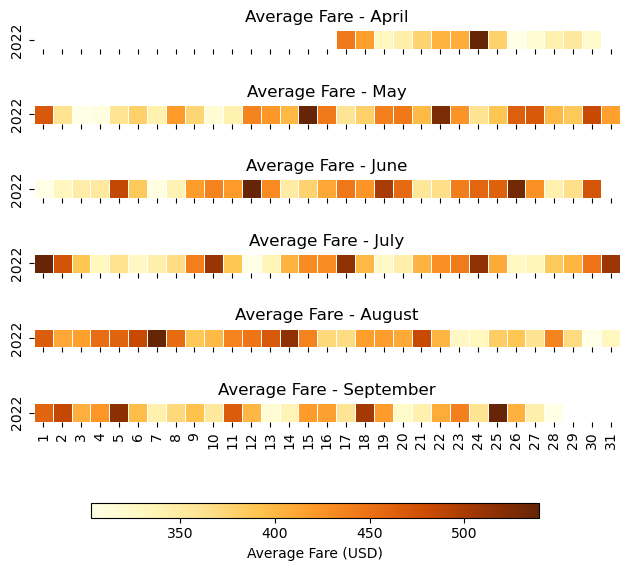

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
flightdf = pd.read_csv('flight_data_clean.csv')
flightdf = flightdf[['flightDate', 'totalFare', 'totalTravelDistance']]

# Convert flightDate to datetime
flightdf['flightDate'] = pd.to_datetime(flightdf['flightDate'])

# make new columns for year, month, and day
flightdf['year'] = flightdf['flightDate'].dt.year
flightdf['month'] = flightdf['flightDate'].dt.month
flightdf['day'] = flightdf['flightDate'].dt.day

# pivot table with average fare by year, month, and day. easier to plot a heatmap and get mean
heatmapData = flightdf.pivot_table(index=['month', 'year'], columns='day', values='totalFare', aggfunc='mean')

# get the months in the data stored at level 0 in the pivot table index
months = heatmapData.index.levels[0]

fig, axes = plt.subplots(nrows=len(months), ncols=1, sharex=True)

for month in months:
    i = months.get_loc(month)  # get the index of the current month
    sns.heatmap(heatmapData.loc[month], cmap='YlOrBr', ax=axes[i], linewidths=0.5, square=True, cbar=False)
    # converts month into datetime object, then formats it to the full month name
    axes[i].set_title('Average Fare - {}'.format(pd.to_datetime(month, format='%m').strftime('%B')))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')  # Remove x and y axis labels

# add color bar at the bottom
cbarAxes = fig.add_axes([0.15, -.1, 0.7, 0.03])  # set figure left, bottom, width, height
cbar = plt.colorbar(axes[0].collections[0], cax=cbarAxes, orientation='horizontal')
cbar.set_label('Average Fare (USD)')

plt.tight_layout()
plt.show()